# Assignment 01

## First exploration of the data

In [1]:
from sklearn import svm, preprocessing, feature_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import threading
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv('../datasets/EEG-data.csv', sep=',', index_col=0)
df

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X4086  X4087  \
0    -56  -50  -64  -91 -135 -140 -134 -114 -115 -126  ...    -37    -43   
1     14   25   31   36   33   33   27   27   21   24  ...    -45    -32   
2   -159 -176 -174 -145 -101  -45    0   29   15   15  ...    -40    -25   
3     34   31   29   19   16   12    3   -1   -5   -8  ...    -34    -33   
4     44   50   46   43   43   46   45   40   36   31  ...      4      5   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
495   12   22   35   45   69   74   79   78   66   43  ...    -22    -21   
496   35   41   56   70   82   91  101  104  112  115  ...      9     11   
497   51   79   94   97  108  114  105   78   47   25  ...     57     48   
498   56   45   39   40   45   53   55   53   58   68  ...    -24    -21   
499  -68  -68  -65  -62  -55  -51  -35  -40  -39  -41  ...    478    378   

     X4088  X4089  X4090  X4091  X4092  X4093  X4094  y  
0      -63    -82   -114   -138   -159   -172   -180  5  
1       -6     -7     -2    -20    -34    -40    -40  5  
2       14     56     73     48    -12    -62   -100  4  
3      -29    -22    -18    -14    -10     -9      0  3  
4        6      6      2      1      0     -1     -4  2  
..     ...    ...    ...    ...    ...    ...    ... ..  
495    -21    -25    -26    -26    -38    -38    -41  5  
496     17     39     54     54     34     29     31  2  
497     36     28     23     30     36     49     47  4  
498    -27    -37    -27    -18      0    -27    -34  1  
499    250    137     57     17      0      7     26  3  

[500 rows x 4095 columns]

## Feature Scaling

### Filtering data

In [139]:

# original data
labels = df[(df['y'] == 3) | (df['y'] == 4)]['y'].values
data = (df[(df['y'] == 3) | (df['y'] == 4)].drop(columns=['y'])).to_numpy()


### Outlier detection

In [140]:
perc_outlier = .5

# Split data into classes
t3 = df[df['y'] == 3].drop(columns=['y'])
t4 = df[df['y'] == 4].drop(columns=['y'])
    
# Find mean and std
t3_mean = np.mean(t3, axis=0)
t4_mean = np.mean(t4, axis=0)
t3_std = np.std(t3, axis=0)
t4_std = np.std(t4, axis=0)

# Find outliers indices
t3_outliers_indices = ((((t3 > t3_mean+t3_std) | (t3 < t3_mean-t3_std)).sum(axis= 1)) > t3.shape[1] * perc_outlier)
t4_outliers_indices = ((((t4 > t4_mean+t4_std) | (t4 < t4_mean-t4_std)).sum(axis= 1)) > t4.shape[1] * perc_outlier)

# Prepare outliers filter
t3_outliers = t3[t3_outliers_indices]
t4_outliers = t4[t4_outliers_indices]

# apply filter to remove outliers
t3 = t3[~t3_outliers_indices]
t4 = t4[~t4_outliers_indices]

# Bring back labels
t3['y'] = 3
t4['y'] = 4

# Concatenate data
labels_no_outliers = pd.concat([t3, t4], ignore_index=True)['y'].values
data_no_outliers = pd.concat([t3, t4], ignore_index=True).drop(columns=['y']).values



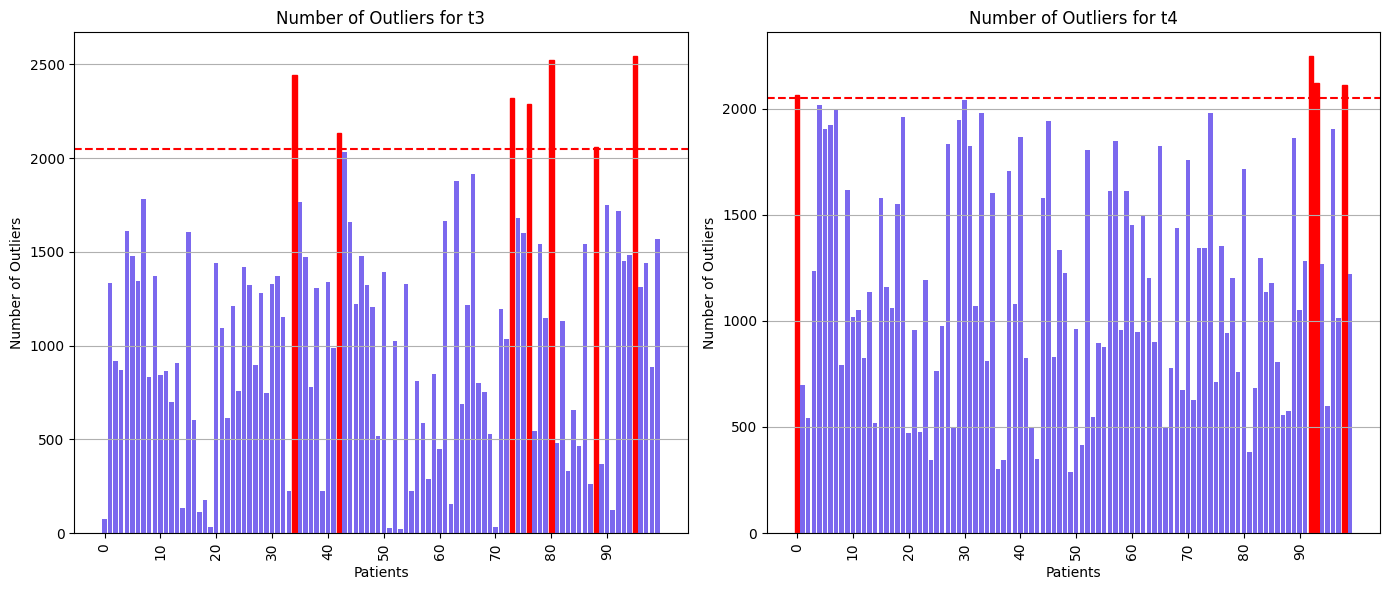

In [141]:
outlier_comparison_t3 = (df[df['y'] == 3].drop(columns=['y']) > t3_mean + t3_std) | (df[df['y'] == 3].drop(columns=['y']) < t3_mean - t3_std)
outlier_count_per_row_t3 = outlier_comparison_t3.sum(axis=1)
threshold = t3.shape[1] * perc_outlier
outlier_threshold_comparison_t3 = outlier_count_per_row_t3 > threshold
outlier_comparison_t4 = (df[df['y'] == 4].drop(columns=['y']) > t4_mean + t4_std) | (df[df['y'] == 4].drop(columns=['y']) < t4_mean - t4_std)
outlier_count_per_row_t4 = outlier_comparison_t4.sum(axis=1)
threshold = t4.shape[1] * perc_outlier
outlier_threshold_comparison_t4 = outlier_count_per_row_t4 > threshold

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars_t3 = plt.bar(np.arange(len(outlier_count_per_row_t3)), outlier_count_per_row_t3, color='mediumslateblue')
plt.xlabel('Patients')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers for t3')
plt.xticks(np.arange(0, len(outlier_count_per_row_t3), 10), rotation=90)
plt.axhline(y=2048, color='red', linestyle='--')
for i, count in enumerate(outlier_count_per_row_t3):
    if count > 2048:
        bars_t3[i].set_color('red')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
bars_t4 = plt.bar(np.arange(len(outlier_count_per_row_t4)), outlier_count_per_row_t4, color='mediumslateblue')
plt.xlabel('Patients')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers for t4')
plt.xticks(np.arange(0, len(outlier_count_per_row_t4), 10), rotation=90)
plt.axhline(y=2048, color='red', linestyle='--')
for i, count in enumerate(outlier_count_per_row_t4):
    if count > 2048:
        bars_t4[i].set_color('red')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Splitting data

In [142]:

X_train, X_test, y_train, y_test = train_test_split(data_no_outliers, labels_no_outliers, test_size=.2, shuffle=True, random_state=53, stratify=labels_no_outliers) # 46 ok, 43 top, 48 ok

X_train_original, X_test_original = X_train, X_test

In [143]:
# add outliers to the test set
X_test_outlier = np.concatenate((X_test, t3_outliers, t4_outliers))
y_test_outlier = np.concatenate((y_test, np.full(t3_outliers.shape[0], 3), np.full(t4_outliers.shape[0], 4)))

### Scaling the data

In [144]:
# Calculate the mean, std, min, max, median, q1, q3, and iqr of the data
mean_data = np.mean(data, axis=0)
std_data = np.std(data, axis=0)
min_data = np.min(data, axis=0)
max_data = np.max(data, axis=0)
median_data = np.median(data, axis=0)
q1 = np.percentile(data, 25, axis=0)
q3 = np.percentile(data, 75, axis=0)
iqr_data = q3 - q1

normalized = (data - mean_data) / std_data
standardized = (data - min_data) / (max_data - min_data)
robust = (data - median_data) / iqr_data


# Normalization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_test_outlier_normalized = scaler.transform(X_test_outlier)

# Standardization
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)
X_test_outlier_standardized = scaler.transform(X_test_outlier)

# Robust scaling
scaler = preprocessing.RobustScaler().fit(X_train)
X_train_robust = scaler.transform(X_train)
X_test_robust = scaler.transform(X_test)
X_test_outlier_robust = scaler.transform(X_test_outlier)


#### This is what the maximum values for each channel looks like before scaling, it gives us an idea of the range of the possible values

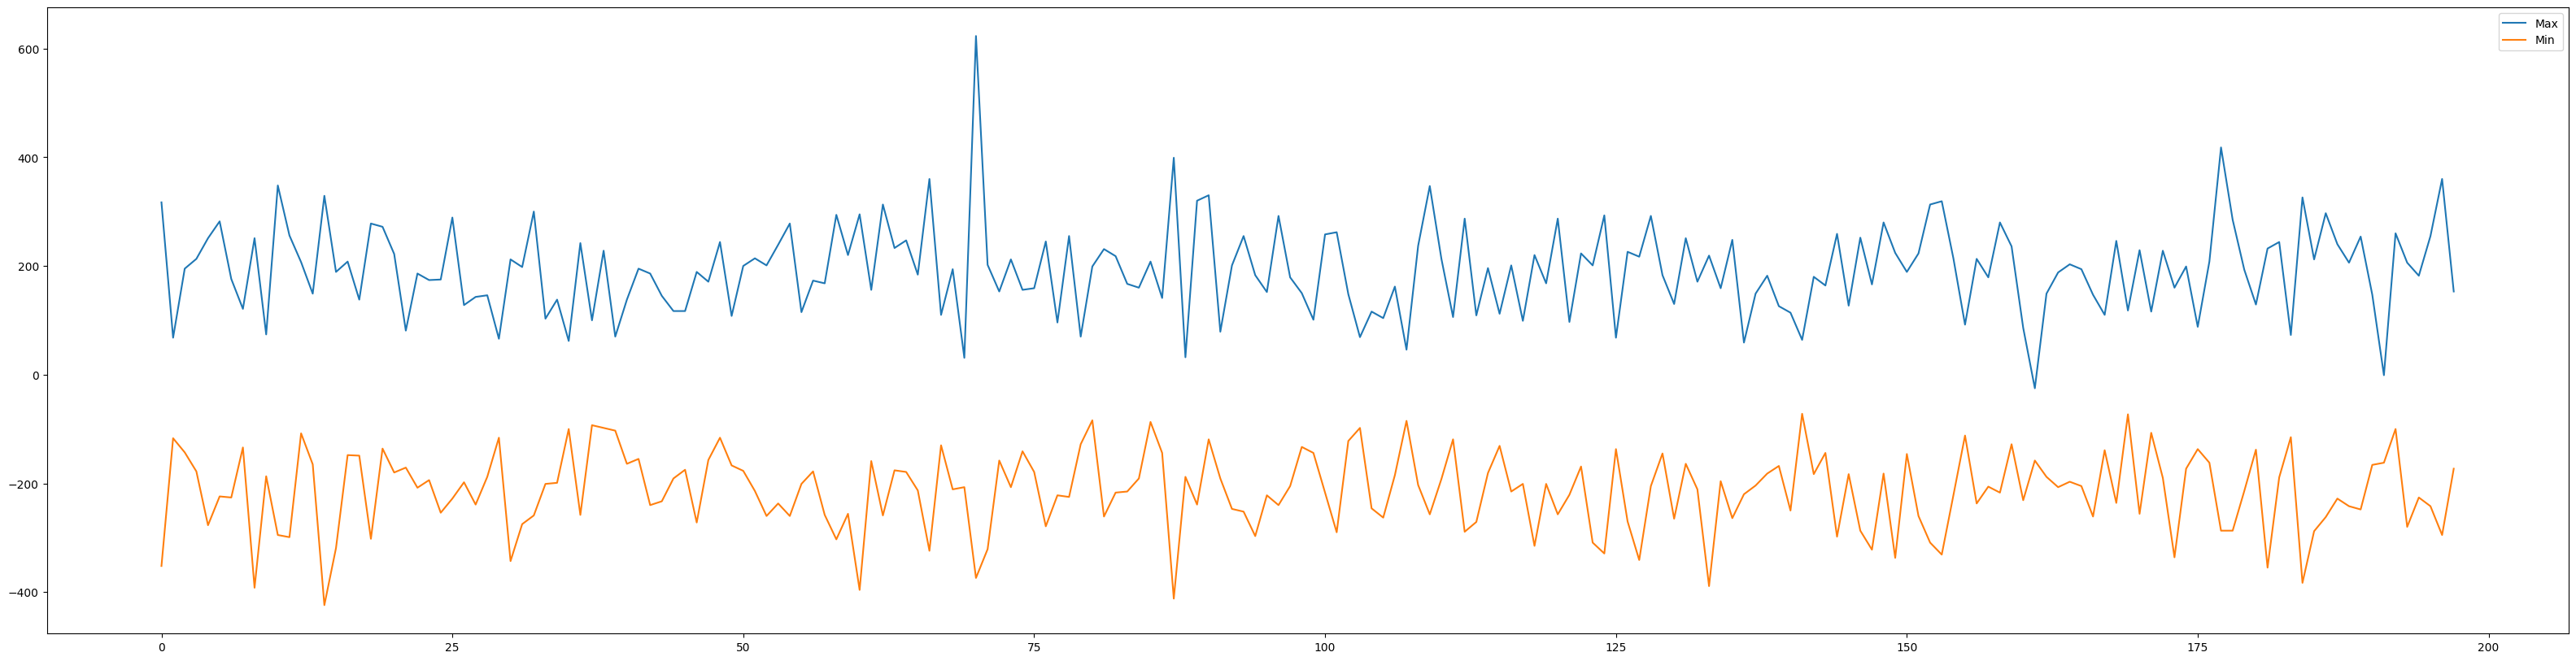

In [145]:
min_ch = []
max_ch = []
plt.figure(figsize=(40, 10))
for channel in data[:-2]:
    min_ch.append(channel.min())
    max_ch.append(channel.max())
    # print(f"{channel.min()},  {channel.max()}")
plt.plot(max_ch, label='Max')
plt.plot(min_ch, label='Min')

plt.legend()
plt.show()

---- 

## Feature selection and extraction

#### Feature selection using preferred features of random forest splits

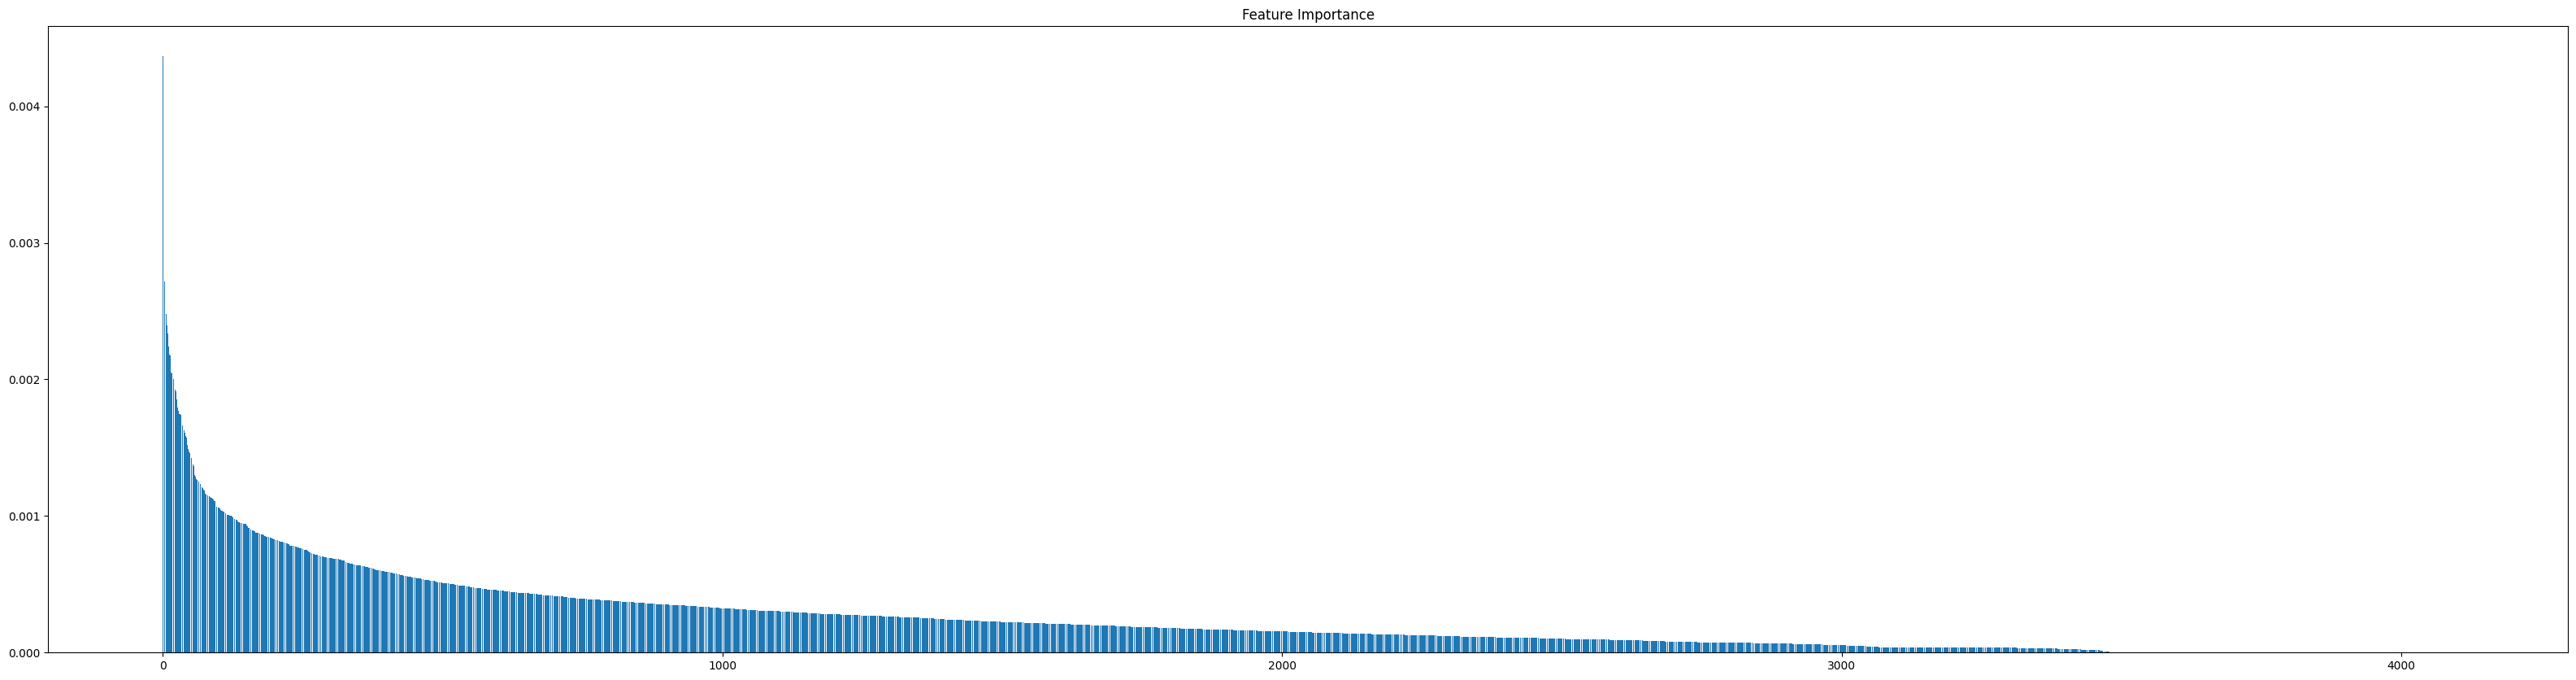

In [146]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]


# Get the top 100 features from the dataset
X_train_tree = X_train_normalized[:, indices[:100]]
X_test_tree = X_test_normalized[:, indices[:100]]

plt.subplots(figsize=(40, 10))

plt.title('Feature Importance')
plt.bar(range(X_train_normalized.shape[1]), importances[indices], align='center')

plt.show()


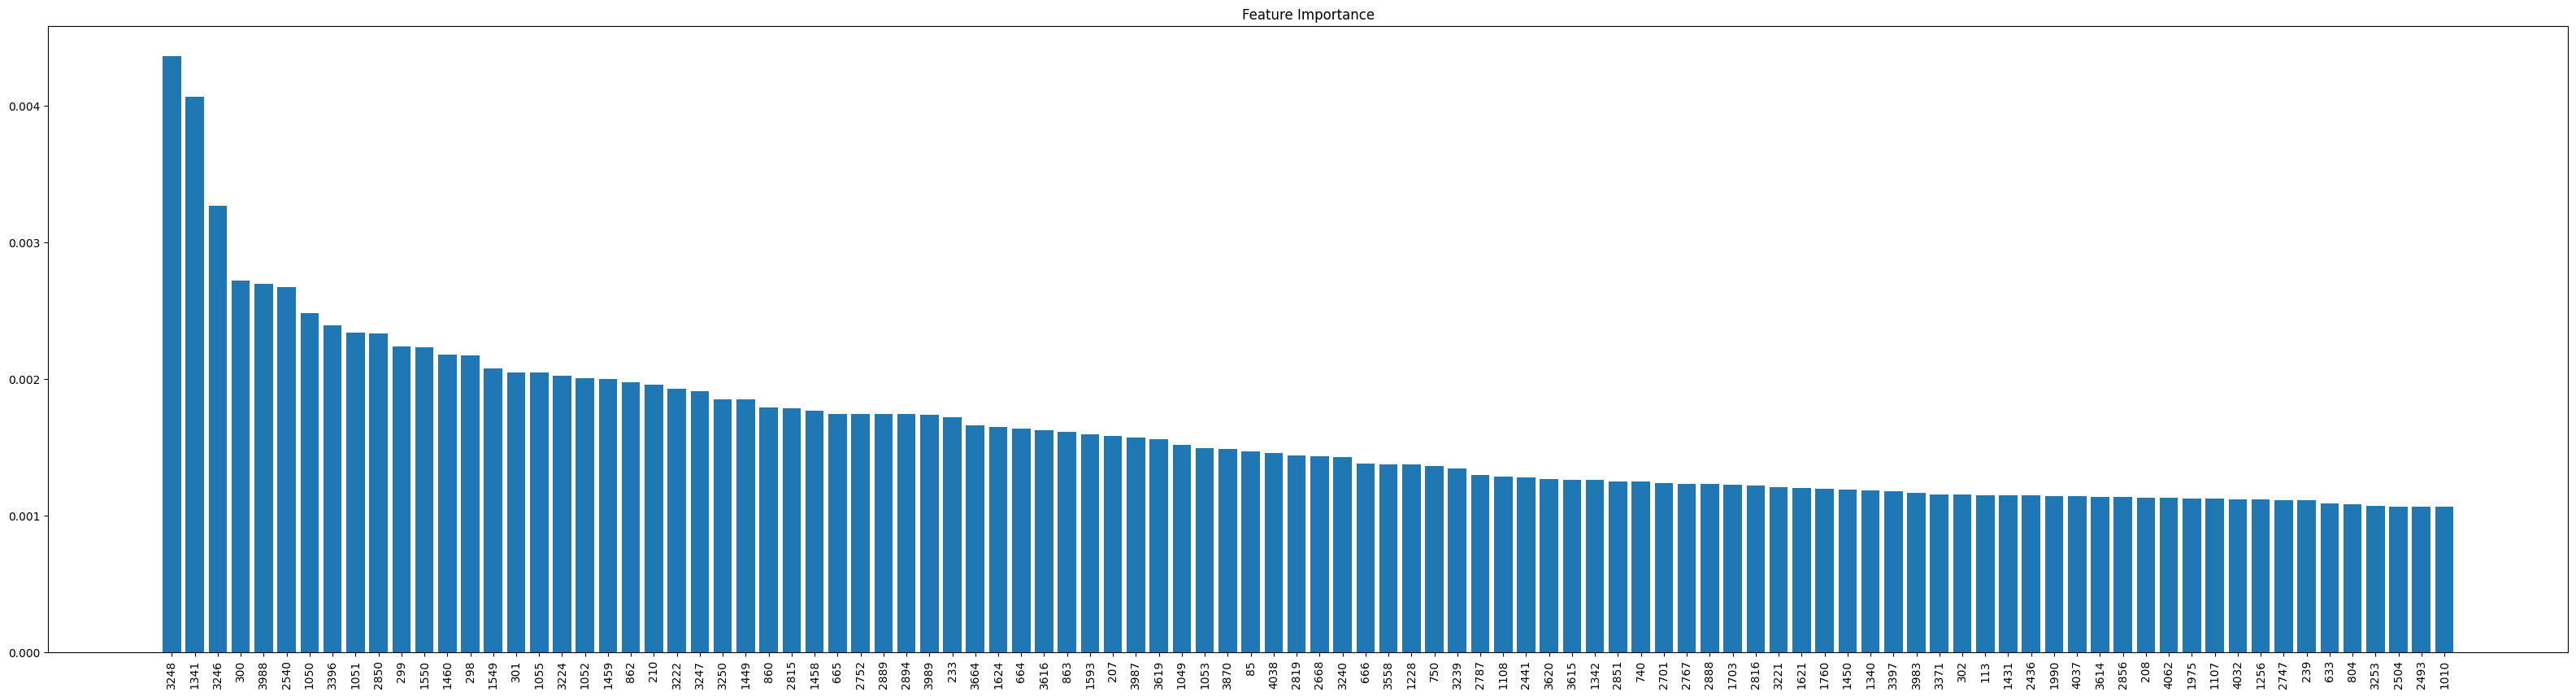

In [147]:
plt.subplots(figsize=(40, 10))

plt.title('Feature Importance')
plt.xticks(range(100), indices[:100], rotation=90)
plt.bar(range(100), importances[indices[:100]], align='center')

plt.show()

####  Feature selection with k-best

In [148]:
# best 1000
selector = feature_selection.SelectKBest(k=1000)
selector.fit(X_train, y_train)
X_train_best_1000 = selector.transform(X_train)
X_test_best_1000 = selector.transform(X_test)

# best 100
selector = feature_selection.SelectKBest(k=100)
selector.fit(X_train, y_train)
X_train_best_100 = selector.transform(X_train)
X_test_best_100 = selector.transform(X_test)

# best 1000 normalized
selector = feature_selection.SelectKBest(k=1000)
selector.fit(X_train_normalized, y_train)
X_train_best_1000_normalized = selector.transform(X_train_normalized)
X_test_best_1000_normalized = selector.transform(X_test_normalized)

# best 100 normalized
selector = feature_selection.SelectKBest(k=100)
selector.fit(X_train_normalized, y_train)
X_train_best_100_normalized = selector.transform(X_train_normalized)
X_test_best_100_normalized = selector.transform(X_test_normalized)


#### Feature extraction with PCA and LDA

In [149]:
# PCA 100 components
pca = PCA(n_components=100)
pca.fit(X_train_normalized)
X_train_pca = pca.transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

# LDA
lda = LDA()
lda.fit(X_train_normalized, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

----

# Training the models

## Criteria to evaluate the models, definition:

<center>

## **Precision**:


Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive. It focuses on the accuracy of positive predictions. The formula for precision is

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

A high precision value indicates that the model has a low false positive rate, meaning it is good at correctly identifying positive instances. However, it may have a higher false negative rate, meaning it may miss some positive instances.  
In our case, this metric is still important but less than the recall, in general, we classify severe cases as being positive (meaning they *need* the therapy), and an higher precision would lead to a low rate of people with the mild disease that don't need the therapy but still receive it since misdiagnosed.

<br><br><br>

## **Recall**:
Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive instances out of all actual positive instances. It focuses on the ability of the model to find all positive instances. The formula for recall is:

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

A high recall value indicates that the model has a low false negative rate, meaning it is good at capturing most of the positive instances. However, it may have a higher false positive rate, meaning it may incorrectly classify some negative instances as positive.  
In our case, this is the metric we want to maximize, since we classify severe cases as being positive (meaning they *need* the therapy), and an higher accuracy would lead to a low rate of people with the severe disease that do **not** receive the therapy since misdiagnosed


<br><br><br>

## **F1-score**:
The F1-score is a harmonic mean of precision and recall. It provides a balanced measure of the model's performance by considering both precision and recall. The formula for F1-score is:

$$\text{F1-score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}}$$

The F1-score ranges from 0 to 1, where 1 indicates the best possible performance. It is useful when we want to find a balance between precision and recall. A higher F1-score indicates a better trade-off between precision and recall.

<br><br><br>

## **Accuracy**:

Accuracy measures the overall correctness of the model's predictions. It is the ratio of the number of correct predictions to the total number of predictions. The formula for accuracy is:

$$\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{True Positives} + \text{False Positives} + \text{True Negatives} + \text{False Negatives}}$$

A high accuracy value indicates that the model is performing well in terms of correctly predicting both positive and negative instances. However, accuracy alone may not be sufficient to evaluate the model's performance, especially when the classes are imbalanced or when the cost of false positives and false negatives is different.

It is important to consider other evaluation metrics such as precision, recall, and F1-score in addition to accuracy to have a comprehensive understanding of the model's performance.
</center>

<br><br><br><br>

## Type of models we're using, brief explanation:

### What is an SVM?

In a classification task, the objective of the Support Vector Machines (SVM) is to maximize the margin between the separating hyperplane (decision  boundary) of the classes.  

The margin is defined as the distance between the separating hyperplane abd the training examples that are closest to this hyperplane, which are the so-called **support vectors**.

### What is the hyperparameter C for SVM? The Slack variable

the SVM optimization objective need to be relaxed for nonlinearly separable data to allow the convergence of the optimization in the presence of misclassifications, under appropriate loss penalization.  
The use of the slack variable, in turn, introduces the variable, which is commonly referred to as C in SVM contexts.  
We can consider C as a hyperparameter for controlling the penalty for misclassification.  
Large values of C correspond to large error penalties, whereas we are less strict about misclassification errors if we choose smaller values for C. We can then use the C parameter to control the width of the margin and therefore tune the bias-variance tradeof

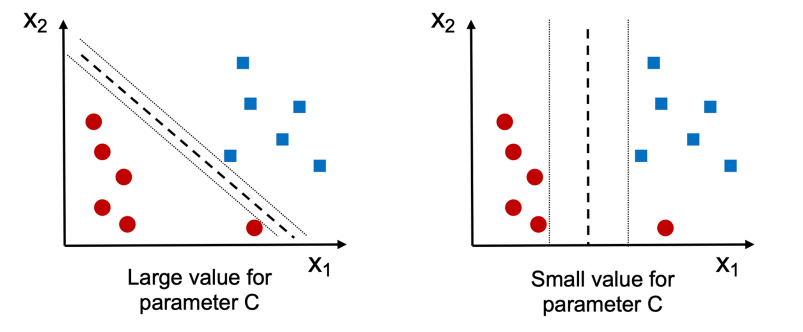

### What is a Decision Tree?

Based on the features in our training dataset, the decision tree model learns a series of questions to infer the class labels of the examples.  
Although the image shown below illustrates the concept of a decision tree based on categorical variables, the same concept applies if our features are real numbers.  

For example, we could simply define a cut-off value in the channel 42 and ask a binary question: “Is the channel 42 ≥ 90?”  
Using the decision algorithm, we start at the tree root and split the data on the feature that results in the largest **information gain**.

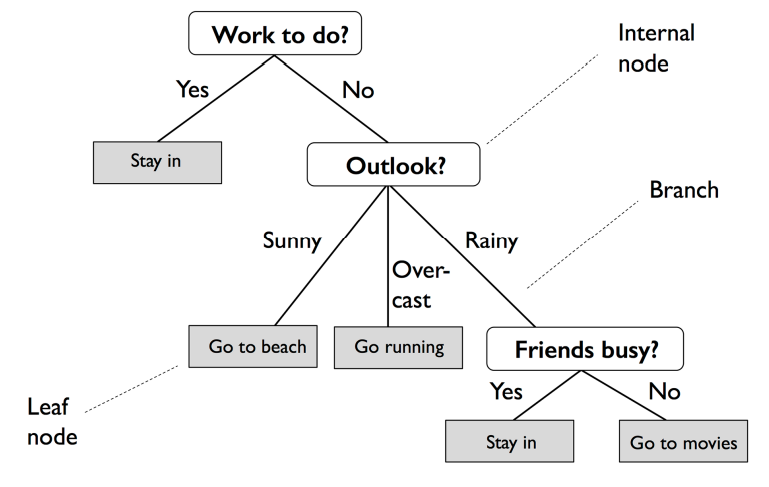

### What is a Random Forest?

A random forest is an ensemble of decision trees, every decision tree evaluates a subset of the totality of the features, it formulates a prediction of the classification of the example being taken into question, these individual tree predictions are then aggregated through a voting process, where the majority decision among all the trees determines the final prediction.  

Random forests are effective at handling overfitting and improving generalization compared to single decision trees, thanks to the diversity of the trees and the voting mechanism.

### What is the hyperparameter criterion for random forests?

Since our objective function at each split in every decision tree is to maximize the information gain, **criterion** is the splitting criteria (impurity measure) used inside this objective function to calculate the information gain.

**Decision trees and random forests are two of the very few machine learning algorithms where we don’t need to worry about feature scaling. Those algorithms are scale-invariant.**

## Hyperparameter tuning

Every consideration has to be applied for each dataset previously created:
Dataset was split in 2:
- Training data
- Test data

#### **Holdout cross-validation:**  
The **training data** is then used to do hyperparameter tuning in a grid search, inside this grid search the training data is split in a smaller training set and validation set, the model is trained and tested on the validation set.  
A disadvantage of the holdout method is that the performance estimate may be very sensitive to how we partition the training dataset into the training and validation subsets: The estimate will vary for different examples of the data.


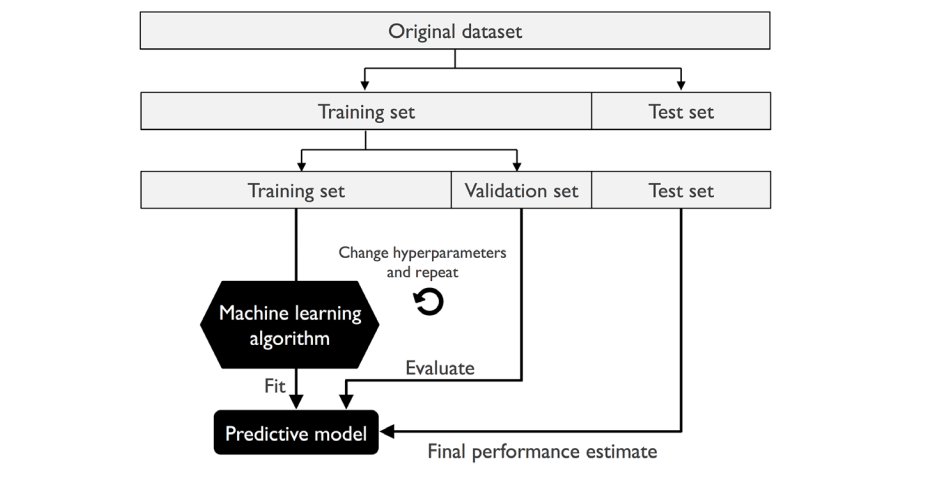

#### **K-fold cross-validation:**  
To mitigate this problem, we randomly split the dataset in k folds, $k-1$ folds (training folds) are used to train the model, and the remaining fold (test fold) is now used just like before, as a validation fold.  
This procedure is repeated $k$ times, we obtaain $k$ models and $k$ estimates.  
We then calculate the average performance of the models based on the different, independent test folds to obtain a performance estimate that is less sensitive to the sub-partitioning of the training data compared to the holdout method.  
Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training dataset and obtain a final performance estimate using the independent test dataset.  
The idea behind fitting a model to the whole training dataset after k-fold cross-validation is that:
- We are interested in a single, final model (versus k individual models)
- Providing more training examples to a learning algorithm usually results in a more accurate and robust model.

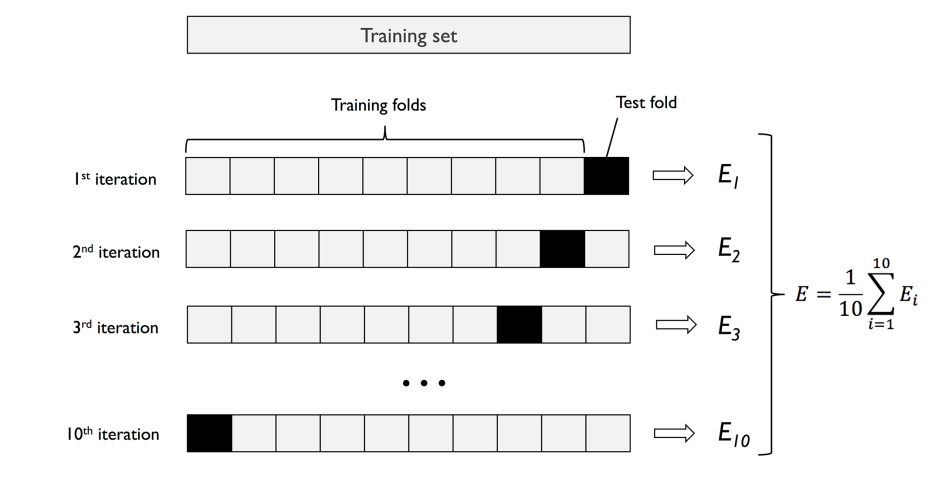

A good standard value for k in k-fold cross-validation is 10, as empirical evidence shows. For instance, experiments by Ron Kohavi on various real world datasets suggest that 10-fold cross-validation offers the best tradeoff between bias and variance  

*(A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection by Kohavi, Ron, International Joint Conference on Artificial Intelligence (IJCAI), 14 (12): 1137-43, 1995, https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf).*

In [150]:
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

def process_fold(model, train_index, test_index, features, labels, results = None, fold_index = None, lock = None):
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X = X_train, y = y_train)
    outputs = model.predict(X_test)
    accuracy = np.sum(outputs == y_test) / len(y_test)
    if lock is not None:
        with lock:
            results[fold_index] = accuracy
            return
    else:
        return accuracy

# Kfold cross validation, no use of functions of sklearn, everything is done manually in order to have more control over the process and to be able to explain it better, this helped a lot in understanding the process
def benchmark(model, train_features, train_labels, folds=10, multiprocessing = False):
    
    results = [None] * folds 
    length_fold = len(train_features) // folds
    indexes = np.arange(0, len(train_features))
    np.random.shuffle(indexes)
    
    # implement multiprocessing with parallel, it's the same as multithreading in the else case, but harder to understand because everything had to be put in a function in just one line
    if multiprocessing:
        
        parallel = Parallel(n_jobs=-1)
        # Disrtibute the folds among the cores
        results = [r for r in parallel(delayed(process_fold)(model, 
                                    indexes[:fold_index * length_fold].tolist() + indexes[fold_index * length_fold + length_fold:].tolist(),
                                    indexes[fold_index * length_fold:fold_index * length_fold + length_fold],
                                    train_features, train_labels) for fold_index in range(folds))]
    # else multithreading, easier to understand by other people, here we use lock to avoid race conditions when accessing the results list which is a shared resource
    else:
        lock = threading.Lock()
        threads = []
        
        for fold_index in range(folds):
            start = fold_index * length_fold 
            end = start + length_fold if fold_index != folds - 1 else len(indexes)
            test_indexes = indexes[start:end] 
            train_indexes = indexes[:start].tolist() + indexes[end:].tolist() 
            
            # Spawn a new thread for each fold
            thread = threading.Thread(target=process_fold, args=(model, train_indexes, test_indexes, train_features, train_labels, results, fold_index, lock))
            threads.append(thread)
            thread.start()
        
        for thread in threads:
            thread.join()
    
    # Sum the results after all processes have finished
    acc = np.sum(results) / len(results)
    std = np.std(results)
    return acc, std


# training on different kernels
def grid_search(train_features, test_features, train_labels, test_labels, params, folds = 10):
    
    results = {'linear': {'accuracy_kfold' : 0}, 'rbf': {'accuracy_kfold' : 0}, 'sigmoid': {'accuracy_kfold' : 0}, 'poly': {'accuracy_kfold' : 0}, 'random_forest': {'accuracy_kfold' : 0}}
    best_accuracy = 0
    gs_params = {}
    models = {}
    
    # Testing every kernel
    for kernel in params['kernel']:
        print(f'\n\n------------------\nTesting {kernel}...\n')
        
        if kernel == 'random_forest':
            for criterion in params['criterion']:
                for i in range(params['n_estimators'][0], params['n_estimators'][1], params['n_estimators'][2]):
                    model = RandomForestClassifier(criterion=criterion, n_estimators=i)
                    accuracy_kfold, std_kfold = benchmark(model,
                                                    train_features,
                                                    train_labels,
                                                    folds = folds,
                                                    multiprocessing = 1)
                    if accuracy_kfold > results[kernel]['accuracy_kfold']:
                        results[kernel] = ({'accuracy_kfold': accuracy_kfold, 'std': std_kfold, 'criterion': criterion, 'n_estimators': i})
            model = RandomForestClassifier(criterion = results[kernel]['criterion'], n_estimators = results[kernel]['n_estimators'], n_jobs=-1)
            gs_params = {'n_estimators': [results[kernel]['n_estimators']], 'criterion': [results[kernel]['criterion']]}
        
        else:
            for c in range(1,2) if kernel == 'linear' else np.arange(params['C'][0], params['C'][1], params['step']):
                for degree in range(1) if kernel!='poly' else np.arange(params['degree'][0], params['degree'][1], 1):
                    model = svm.SVC(kernel=kernel, C=c, degree=degree, gamma='auto')
                    accuracy_kfold, std_kfold = benchmark(model,
                                                    train_features,
                                                    train_labels,
                                                    folds = folds)
                    
                    if accuracy_kfold >= results[kernel]['accuracy_kfold']:
                        results[kernel] = ({'C': c, 'degree': degree, 'accuracy_kfold': accuracy_kfold, 'std': std_kfold})
                    
            model = svm.SVC(kernel=kernel,
                            C=results[kernel]['C'],
                            degree=results[kernel].get('degree', 0))
            gs_params = {'kernel' : [kernel] , 'C': [results[kernel]['C']], 'degree': [results[kernel].get('degree', 0)]}
        
        # Training phase, save every candidate model since we need them for the ensemble, but later check if the candidate is the best of the bests
        candidate = model.fit(train_features, train_labels)
        outputs_candidate = candidate.predict(test_features)
        accuracy = np.sum(outputs_candidate == test_labels) / len(test_labels)
        results[kernel].update({'accuracy' : accuracy})
        models[kernel] = candidate
        
        # Check if candidate is the best of the bests, and save it
        if accuracy > best_accuracy:
            best_model = candidate
            best_accuracy = accuracy
            print(f'New best model: {best_accuracy}')
        
        # See how the model grid search performs compared to our search        
        clf = GridSearchCV(model, n_jobs=-1, param_grid={**gs_params})
        clf.fit(train_features, train_labels)
        outputs_GS_model = clf.predict(test_features)
        GS_accuracy = np.sum(outputs_GS_model == test_labels) / len(test_labels)
        
                
        
        # Testing phase: print results and comparison with grid search
        print (f'\n\n Results on {kernel}:\n')
        print (f'''\
                Grid search: {GS_accuracy}
                Our search:  {results[kernel]["accuracy"]}
                
                Scores on kfold:
                Our search: {results[kernel]["accuracy_kfold"]}
                Grid search: {benchmark(model = clf.best_estimator_, train_features = train_features, train_labels = train_labels, folds = folds, multiprocessing=True)}
                
                --------------------------------------
                Detailed Report:
                
                Grid search:
                {classification_report(test_labels, outputs_GS_model)}
                
                Our search:
                {classification_report(test_labels, outputs_candidate)}
                
                Parameters:
                Grid search:
                {clf.best_params_}
                Our search:
                {candidate.get_params()}
                --------------------------------------
                All results:
                {results}''')
    
    return best_model, models


## Finding the best models for each dataset previously created

In [151]:
# Parameters for our grid search
parameters = {'kernel':['linear', 'rbf', 'sigmoid', 'poly', 'random_forest'],
              'C':[0.1, 20],
              'degree':[1, 5],
              'gamma':(0.1, 1, 0.1),
              'criterion': ('gini', 'entropy', 'log_loss'),
              'n_estimators' : (100, 1000, 100),
              'step': 0.3}


best_models = {}

datasets = ['original', 'normalized', 'standardized', 'robust', 'best_1000', 'best_100', 'best_1000_normalized', 'best_100_normalized', 'pca','tree']

for ds in datasets:
    print(f'################################################# Working on {ds} dataset')
    best_model, models = grid_search(train_features = eval(f'X_train_{ds}'),
                        test_features = eval(f'X_test_{ds}'),
                        train_labels = y_train,
                        test_labels = y_test,
                        params = parameters,
                        folds = 5)
    best_models.update({ds: {'best_model': best_model, 'test_labels': y_test, 'test_features': eval(f'X_test_{ds}'), 'train_labels': y_train, 'train_features': eval(f'X_train_{ds}'),'models' : models}})

################################################# Working on original dataset


------------------
Testing linear...

New best model: 0.8157894736842105




 Results on linear:

                Grid search: 0.8157894736842105
                Our search:  0.8157894736842105
                
                Scores on kfold:
                Our search: 0.7808602150537635
                Grid search: (0.7133333333333334, 0.11661903789690603)
                
                --------------------------------------
                Detailed Report:
                
                Grid search:
                              precision    recall  f1-score   support

           3       0.75      0.95      0.84        19
           4       0.93      0.68      0.79        19

    accuracy                           0.82        38
   macro avg       0.84      0.82      0.81        38
weighted avg       0.84      0.82      0.81        38

                
                Our search:
                              precision    recall  f1-score   support

           3       0.75      0.95      0.84        19
           4       0.93      0.68      0.79      

## Adding  outliers datasets

In [152]:
# adding the datasets with outliers, we will use the same best models as the original dataset, but we will test them on the outliers
best_models.update({'outliers': {'best_model': best_models['original']['best_model'], 'test_labels': y_test_outlier, 'test_features': X_test_outlier, 'models' : best_models['original']['models'], 'train_labels': y_train, 'train_features': X_train}})
best_models.update({'outliers_normalized': {'best_model': best_models['normalized']['best_model'], 'test_labels': y_test_outlier, 'test_features': X_test_outlier_normalized, 'models' : best_models['normalized']['models'], 'train_labels': y_train, 'train_features': X_train_normalized}})
best_models.update({'outliers_standardized': {'best_model': best_models['standardized']['best_model'], 'test_labels': y_test_outlier, 'test_features': X_test_outlier_standardized, 'models' : best_models['standardized']['models'], 'train_labels': y_train, 'train_features': X_train_standardized}})
best_models.update({'outliers_robust': {'best_model': best_models['robust']['best_model'], 'test_labels': y_test_outlier, 'test_features': X_test_outlier_robust, 'models' : best_models['robust']['models'], 'train_labels': y_train, 'train_features': X_train_robust}})
datasets.append('outliers')
datasets.append('outliers_normalized')
datasets.append('outliers_standardized')
datasets.append('outliers_robust')

## Constructing an Ensemble

In [153]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators

# better approach than the simple voting classifier, this one allows to weight the classifiers, we basically use the abstract class BaseEstimator and ClassifierMixin to create our own classifier
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
        
    
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability'"
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                            f' weights must be equal'
                            f'; got {len(self.weights)} weights,'
                            f' {len(self.classifiers)} classifiers')
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        # we fit the label encoder to the labels and store the classes in self.classes_, this is important for the inverse_transform method
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    # this works pretty well now, had to mix the predict_proba and decision_function methods, as the classifiers can have either one or the other, hope it's right concetually
    def predict_proba(self, X):
        probas = []
        for clf in self.classifiers:
            if hasattr(clf, 'predict_proba'):
                probas.append(clf.predict_proba(X))
            else:
                probas.append(clf.decision_function(X))
        
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba


    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out




In [154]:
# first simple working example,
class SimpleEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        
        # majority vote
        predictions = np.array(predictions)
        return np.round(np.mean(predictions, axis=0))

    def predict_proba(self, X):
        predictions = []
        for model in self.models:
            if hasattr(model, 'predict_proba'):
                predictions.append(model.predict_proba(X))
            else:
                predictions.append(model.decision_function(X))
        return np.mean(predictions, axis=0)
    

In [155]:
for ds in datasets:
    #megatron = SimpleEnsemble(models=[best_models[ds]['models'][model] for model in best_models[ds]['models']])
    # ditched the simple ensemble, it's not as good as the MajorityVoteClassifier
    megatron = MajorityVoteClassifier(classifiers=[best_models[ds]['models'][model] for model in best_models[ds]['models']])
    megatron.fit(best_models[ds]['train_features'], best_models[ds]['train_labels'])
    predictions = megatron.predict(best_models[ds]['test_features'])
    best_models[ds].update({'ensemble': megatron})

----

## Plotting the data

### This is a plot that gives us a general idea of the performance on the test set of the best models tuned on each training set previously created

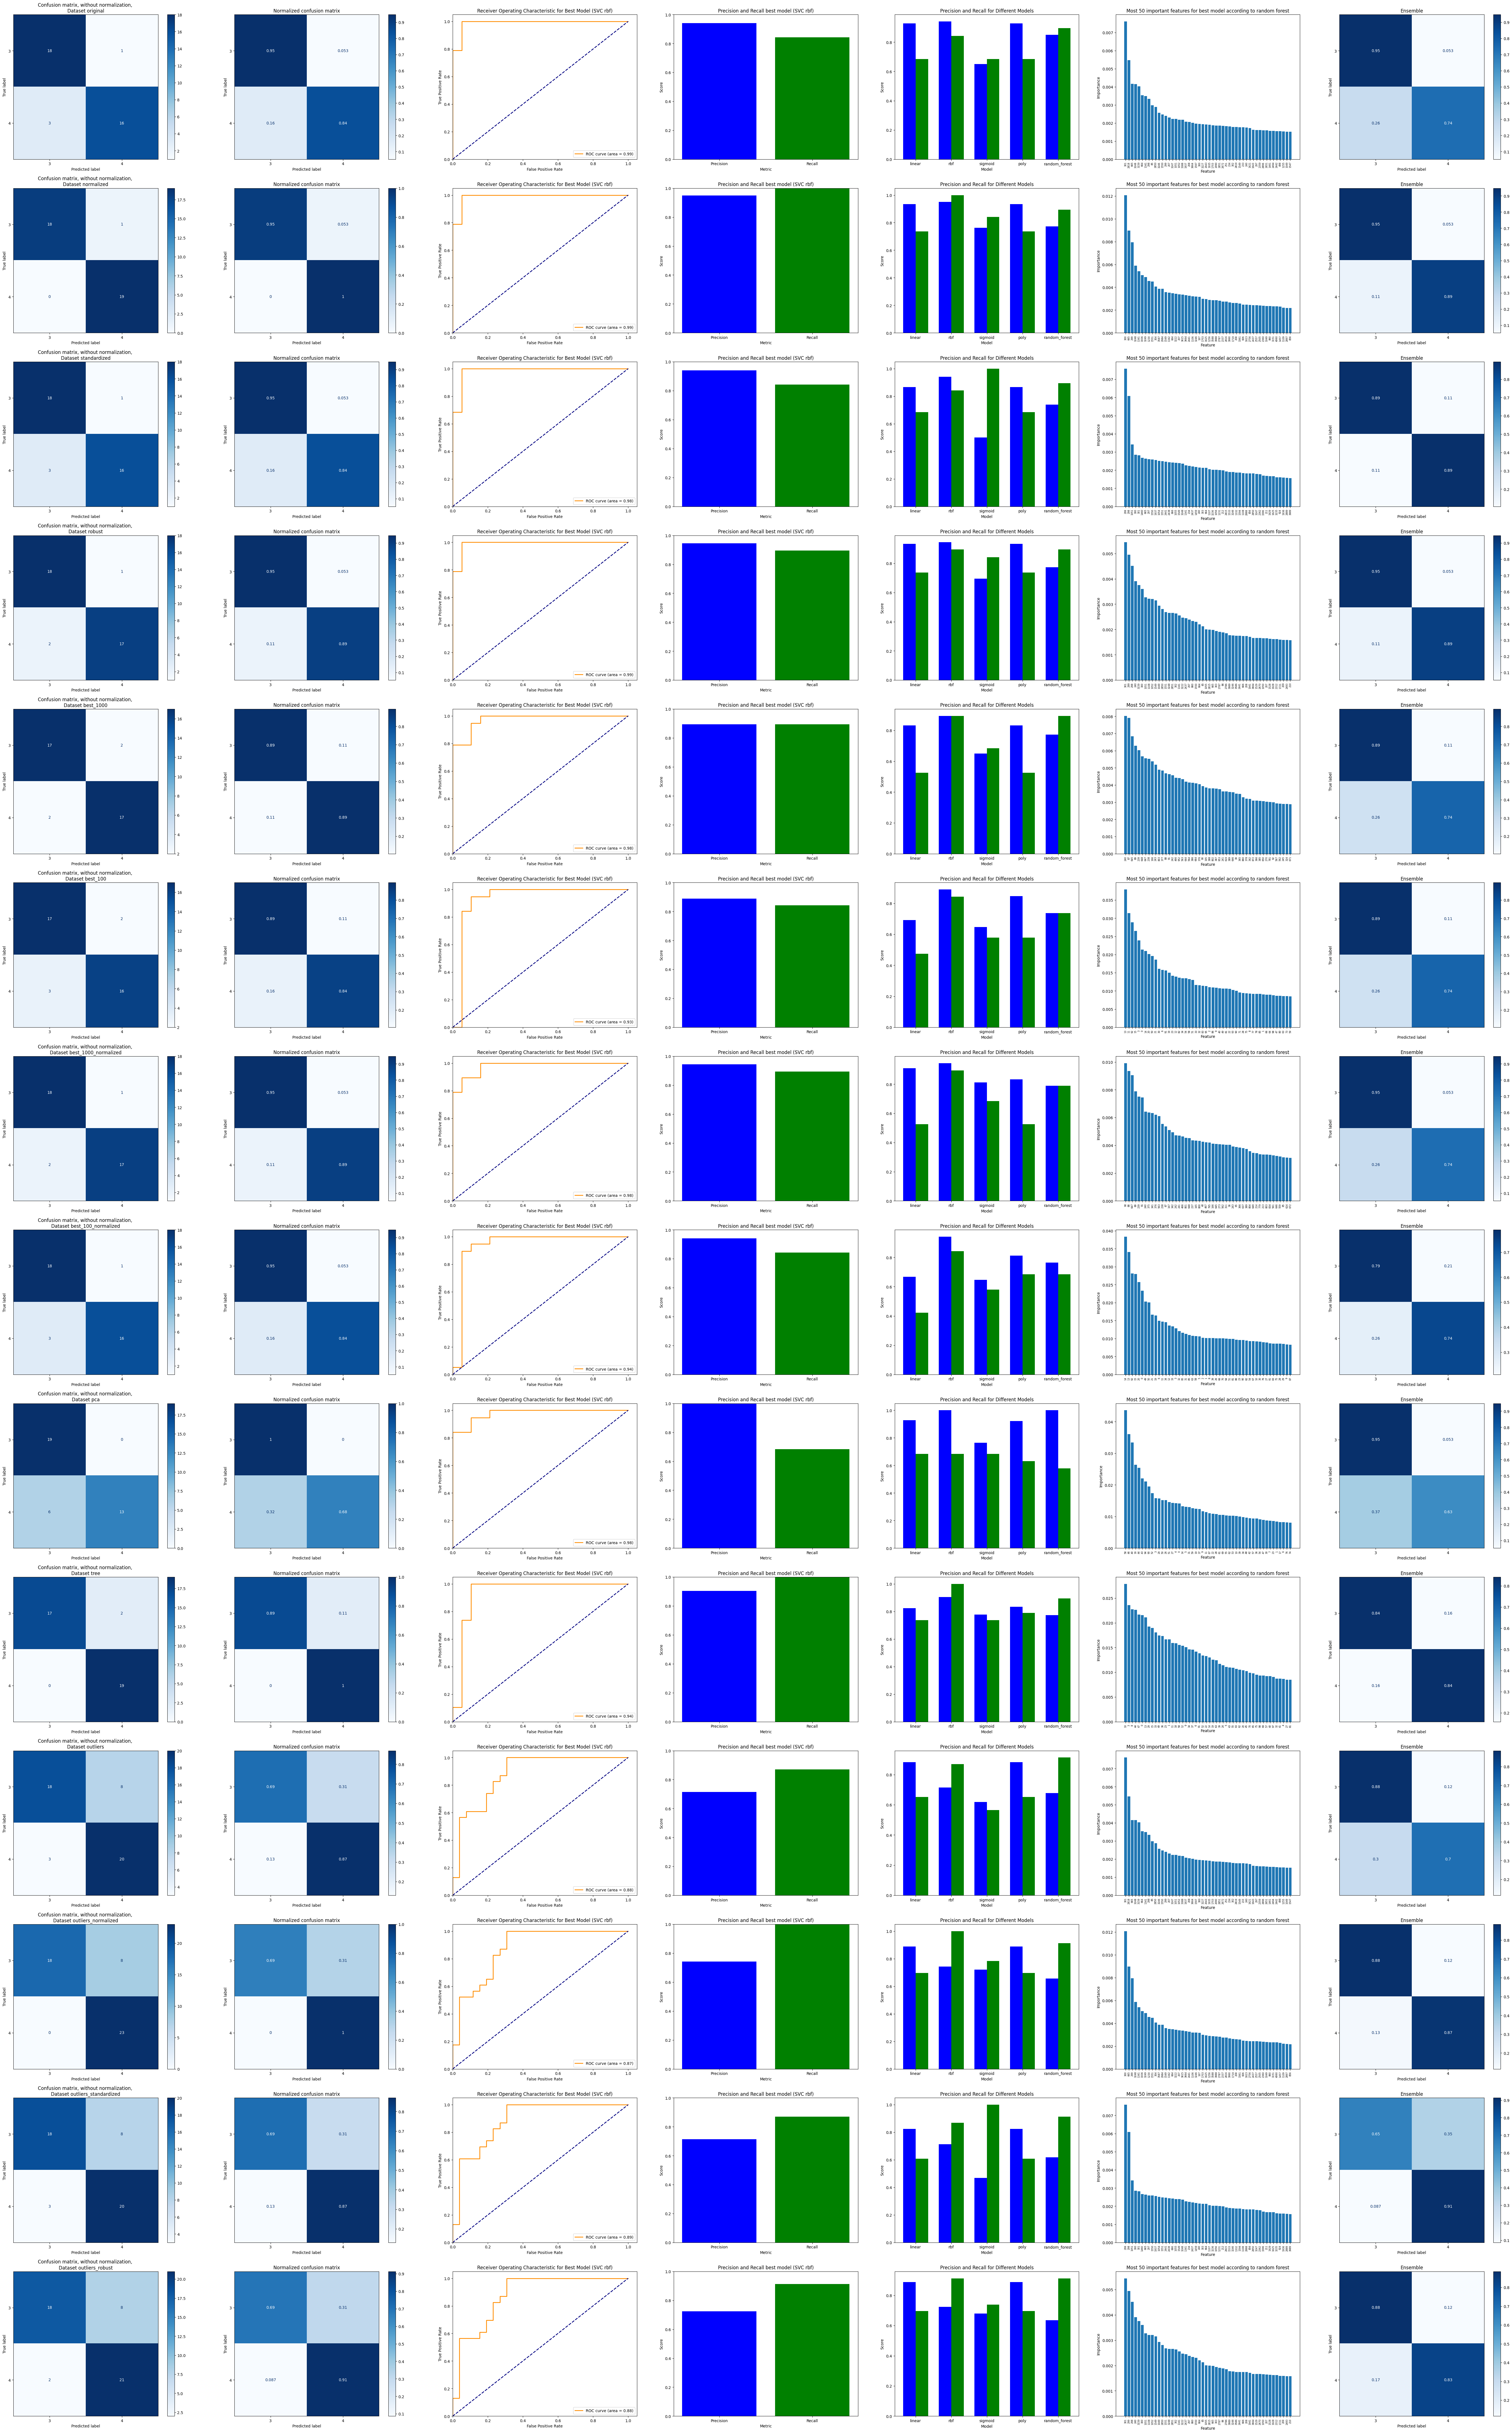

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [156]:

from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(len(best_models), 7, figsize=(70, 8 * len(best_models)))

for i, dataset in enumerate(best_models):
    
    predictions = best_models[dataset]['best_model'].predict(best_models[dataset]['test_features'])
    ds_results = best_models[dataset]
    
    # calculate everything atomically! no use of the confusion_matrix function or any other function when possible
    TN = np.sum((predictions == 3) & (ds_results['test_labels'] == 3))
    TP = np.sum((predictions == 4) & (ds_results['test_labels'] == 4))
    FP = np.sum((predictions == 4) & (ds_results['test_labels'] == 3))
    FN = np.sum((predictions == 3) & (ds_results['test_labels'] == 4))


    ############################################################################## Confusion Matrix for best model
    titles_options = [
        ("Confusion matrix, without normalization, \nDataset " + dataset, None),
        ("Normalized confusion matrix", "true"),
    ]

    for j, (title, normalize) in enumerate(titles_options):
        disp = ConfusionMatrixDisplay.from_estimator(
            ds_results['best_model'],
            ds_results['test_features'],
            ds_results['test_labels'],
            display_labels = [3, 4],
            cmap = plt.cm.Blues,
            normalize = normalize,
            ax = axs[i][j]  # Plot in the i-th subplot
        )
        disp.ax_.set_title(title)

    
    ############################################################################## ROC Curve for best model
    
    if ds_results['best_model'].__class__.__name__ == 'RandomForestClassifier':
        predictions = ds_results['best_model'].predict_proba(ds_results['test_features'])[:, 1]
        name = 'random forest'
    else:
        predictions = ds_results['best_model'].decision_function(ds_results['test_features'])
        name = ds_results['best_model'].__class__.__name__ + ' ' + ds_results['best_model'].kernel
        
    fpr, tpr, thresholds = roc_curve(ds_results['test_labels'], predictions, pos_label=4)
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure()
    lw = 2
    axs[i][2].plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[i][2].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axs[i][2].set_xlim([0.0, 1.05])
    axs[i][2].set_ylim([0.0, 1.05])
    axs[i][2].set_xlabel('False Positive Rate')
    axs[i][2].set_ylabel('True Positive Rate')
    axs[i][2].set_title('Receiver Operating Characteristic for Best Model (%s)' % name)
    axs[i][2].legend(loc="lower right")
    
      
    
    ############################################################################## Precision and Recall for best model
    
    axs[i][3].bar(['Precision', 'Recall'], [TP / (TP + FP), TP / (TP + FN)], color=['blue', 'green'])
    axs[i][3].set_title(f'Precision and Recall best model ({name})')
    axs[i][3].set_ylim(0, 1)
    axs[i][3].set_ylabel('Score')
    axs[i][3].set_xlabel('Metric')
    
    ############################################################################## Precision and Recall for all models
    
    Precision_recall_models = {}

    for model in ds_results['models']:
        predictions = ds_results['models'][model].predict(ds_results['test_features'])
        TN = np.sum((predictions == 3) & (ds_results['test_labels'] == 3))
        TP = np.sum((predictions == 4) & (ds_results['test_labels'] == 4))
        FP = np.sum((predictions == 4) & (ds_results['test_labels'] == 3))
        FN = np.sum((predictions == 3) & (ds_results['test_labels'] == 4))
        if TP + FP == 0:
            print(f'{model} has no true positives, this is results: {TP, FP, FN}')
        
        #print(f'model: {model},  TP: {TP}, FP: {FP}, FN: {FN}\n')
        precision = TP / (TP + FP) if (TP + FP != 0)  else 0
        recall = TP / (TP + FN) if (TP + FN != 0) else 0
        #print(f'{model} : {precision}, {recall}\n\n')
        Precision_recall_models.update({model : {'precision': precision, 'recall': recall}})



    # Define models and their colors
    models = list(Precision_recall_models.keys())
    colors = ['blue', 'green']

    # Set the width of the bars
    bar_width = 0.35

    # Define the index for the bars
    index = np.arange(len(models))

    # Plot bars for precision and recall for each model
    for j, model in enumerate(models):
        precision = Precision_recall_models[model]['precision']
        recall = Precision_recall_models[model]['recall']
        axs[i][4].bar(index[j] - bar_width/2, precision, bar_width, label=str(model) + ' Precision', color=colors[0])
        axs[i][4].bar(index[j] + bar_width/2, recall, bar_width, label=str(model) + ' Recall', color=colors[1])

    # Set labels and title
    axs[i][4].set_ylabel('Score')
    axs[i][4].set_xlabel('Model')
    axs[i][4].set_title('Precision and Recall for Different Models')
    axs[i][4].set_xticks(index)
    axs[i][4].set_xticklabels(models)
    
    
    ############################################################################## Most important features according to random forest
    
    importances = ds_results['models']['random_forest'].feature_importances_
    indices = np.argsort(importances)[::-1]
    #axs[i][5].bar(range(ds_results['features'].shape[1]), importances[indices], align='center')
    axs[i][5].bar(range(50), importances[indices][:50], align='center')
    axs[i][5].set_title('Most 50 important features for best model according to random forest')
    axs[i][5].set_xticks(range(50), indices[:50], rotation=90, fontsize=6)
    axs[i][5].set_xticklabels(indices[:50])
    axs[i][5].set_ylabel('Importance')
    axs[i][5].set_xlabel('Feature')
    
    
    ############################################################################## Confusion Matrix for ensemble model
    
    
    predictions = ds_results['ensemble'].predict(ds_results['test_features'])
    
    disp = ConfusionMatrixDisplay.from_predictions(
        ds_results['test_labels'],
        predictions,
        display_labels = [3, 4],
        cmap = plt.cm.Blues,
        normalize = 'true',
        ax = axs[i][6])  # Plot in the i-th subplot
    disp.ax_.set_title('Ensemble')
    

# Show the plots
plt.tight_layout()
plt.show()


----
# Playground
---

# **La roba scritta qui è per testing, non fa parte del progetto, se funziona e quando funziona è da capire come spostarla sopra**

## Creating an ensemble

In [93]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
        
    
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability'"
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                            f' weights must be equal'
                            f'; got {len(self.weights)} weights,'
                            f' {len(self.classifiers)} classifiers')
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

        
    def predict_proba(self, X):
        probas = []
        for clf in self.classifiers:
            if hasattr(clf, 'predict_proba'):
                probas.append(clf.predict_proba(X))
            else:
                probas.append(clf.decision_function(X))
        
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba


    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [94]:
megatron = MajorityVoteClassifier(classifiers=[best_models['tree']['models'][model] for model in best_models['tree']['models']])
megatron.fit(X_train_tree, y_train)
predictions = megatron.predict(X_test_tree)
score = np.sum(predictions == y_test) / len(y_test)
print(classification_report(y_test, predictions)), score

              precision    recall  f1-score   support

           3       0.90      0.95      0.92        19
           4       0.94      0.89      0.92        19

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



(None, 0.9210526315789473)

In [95]:
megatron = MajorityVoteClassifier(classifiers=[svm.SVC(kernel='linear'),
                                               svm.SVC(kernel='rbf'),
                                               svm.SVC(kernel='sigmoid'),
                                               svm.SVC(kernel='poly'),
                                               RandomForestClassifier()])
megatron.get_params()

{'svc-1': SVC(kernel='linear'),
 'svc-2': SVC(),
 'svc-3': SVC(kernel='sigmoid'),
 'svc-4': SVC(kernel='poly'),
 'randomforestclassifier': RandomForestClassifier(),
 'svc-1__C': 1.0,
 'svc-1__break_ties': False,
 'svc-1__cache_size': 200,
 'svc-1__class_weight': None,
 'svc-1__coef0': 0.0,
 'svc-1__decision_function_shape': 'ovr',
 'svc-1__degree': 3,
 'svc-1__gamma': 'scale',
 'svc-1__kernel': 'linear',
 'svc-1__max_iter': -1,
 'svc-1__probability': False,
 'svc-1__random_state': None,
 'svc-1__shrinking': True,
 'svc-1__tol': 0.001,
 'svc-1__verbose': False,
 'svc-2__C': 1.0,
 'svc-2__break_ties': False,
 'svc-2__cache_size': 200,
 'svc-2__class_weight': None,
 'svc-2__coef0': 0.0,
 'svc-2__decision_function_shape': 'ovr',
 'svc-2__degree': 3,
 'svc-2__gamma': 'scale',
 'svc-2__kernel': 'rbf',
 'svc-2__max_iter': -1,
 'svc-2__probability': False,
 'svc-2__random_state': None,
 'svc-2__shrinking': True,
 'svc-2__tol': 0.001,
 'svc-2__verbose': False,
 'svc-3__C': 1.0,
 'svc-3__break_t

In [96]:
# some heavy stuff here
grid = GridSearchCV(estimator = megatron, param_grid = {'svc-1__C' :  [1], 'svc-2__C' : np.arange(1, 10, 1), 'svc-3__C' :  np.arange(1, 10, 2), 'svc-4__C' :  np.arange(1, 10, 1), 'randomforestclassifier__n_estimators' :  np.arange(100, 1000, 100), 'svc-3__degree' :  np.arange(1, 5, 1)}, n_jobs=-1, verbose =3).fit(X_train_best_100_normalized, y_train)

Fitting 5 folds for each of 14580 candidates, totalling 72900 fits
[CV 5/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=1;, score=0.800 total time=   0.1s
[CV 1/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=1;, score=0.645 total time=   0.1s
[CV 2/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=1;, score=0.633 total time=   0.1s
[CV 3/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=1;, score=0.733 total time=   0.1s
[CV 2/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=2;, score=0.633 total time=   0.1s
[CV 2/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=3;, score=0.667 total time=   0.1s
[CV 4/5] END randomfo

[CV 3/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=8;, score=0.700 total time=   0.2s
[CV 5/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=6;, score=0.833 total time=   0.2s
[CV 1/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=9;, score=0.645 total time=   0.2s
[CV 1/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=8;, score=0.645 total time=   0.2s
[CV 3/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=2, svc-4__C=1;, score=0.700 total time=   0.2s
[CV 2/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=1, svc-3__degree=1, svc-4__C=9;, score=0.667 total time=   0.2s
[CV 4/5] END randomforestclassifier__n_estimators=100, svc-1__C=1, svc-2__C=1, svc-3__C=

KeyboardInterrupt: 

In [ ]:
np.sum(grid.best_estimator_.predict(X_test_best_100_normalized) == y_test) / len(y_test)

0.5789473684210527

In [ ]:
grid.best_estimator_.get_params()

{'svc-1': SVC(C=1, kernel='linear'),
 'svc-2': SVC(C=3),
 'svc-3': SVC(C=3, degree=2, kernel='sigmoid'),
 'svc-4': SVC(C=1, kernel='poly'),
 'randomforestclassifier': RandomForestClassifier(n_estimators=200),
 'svc-1__C': 1,
 'svc-1__break_ties': False,
 'svc-1__cache_size': 200,
 'svc-1__class_weight': None,
 'svc-1__coef0': 0.0,
 'svc-1__decision_function_shape': 'ovr',
 'svc-1__degree': 3,
 'svc-1__gamma': 'scale',
 'svc-1__kernel': 'linear',
 'svc-1__max_iter': -1,
 'svc-1__probability': False,
 'svc-1__random_state': None,
 'svc-1__shrinking': True,
 'svc-1__tol': 0.001,
 'svc-1__verbose': False,
 'svc-2__C': 3,
 'svc-2__break_ties': False,
 'svc-2__cache_size': 200,
 'svc-2__class_weight': None,
 'svc-2__coef0': 0.0,
 'svc-2__decision_function_shape': 'ovr',
 'svc-2__degree': 3,
 'svc-2__gamma': 'scale',
 'svc-2__kernel': 'rbf',
 'svc-2__max_iter': -1,
 'svc-2__probability': False,
 'svc-2__random_state': None,
 'svc-2__shrinking': True,
 'svc-2__tol': 0.001,
 'svc-2__verbose': F

In [ ]:
class SimpleEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        
        # majority vote
        predictions = np.array(predictions)
        return np.round(np.mean(predictions, axis=0))

    def predict_proba(self, X):
        predictions = []
        for model in self.models:
            if hasattr(model, 'predict_proba'):
                predictions.append(model.predict_proba(X))
            else:
                predictions.append(model.decision_function(X))
        return np.mean(predictions, axis=0)
    
for ds in datasets:
    megatron = SimpleEnsemble(models=[best_models[ds]['models'][model] for model in best_models[ds]['models']])
    ultratron = MajorityVoteClassifier(classifiers=[best_models[ds]['models'][model] for model in best_models[ds]['models']])
    ultratron.fit(eval(f'X_train_{ds}'), y_train)
    
    print("################################################# megatron")
    predictions = megatron.predict(best_models[ds]['features'])
    score = np.sum(predictions == best_models[ds]['labels']) / len(best_models[ds]['labels'])
    print(f"Dataset: {ds} - Score: {score}")
    print(classification_report(best_models[ds]['labels'], predictions))
    
    print("################################################# ultratron")
    predictions = ultratron.predict(best_models[ds]['features'])
    score = np.sum(predictions == best_models[ds]['labels']) / len(best_models[ds]['labels'])
    print(f"Dataset: {ds} - Score: {score}")
    print(classification_report(best_models[ds]['labels'], predictions))
    print("\n\n\n\n")
    

################################################# megatron


KeyError: 'features'

In [ ]:
best_models['best_100']['models']

{'linear': SVC(C=1, degree=0, kernel='linear'),
 'rbf': SVC(C=10.0, degree=0),
 'sigmoid': SVC(C=1.9000000000000001, degree=0, kernel='sigmoid'),
 'poly': SVC(C=4.1, degree=1, kernel='poly'),
 'random_forest': RandomForestClassifier(criterion='entropy', n_estimators=800, n_jobs=-1)}

In [ ]:
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv

# experimental feature of sklearn, looks promising but way too slow with these hyperparams
test = HalvingGridSearchCV(svm.SVC(), [{'kernel': ['rbf'], 'C': np.arange(1,100,1), 'degree': np.arange(1,10,1), 'gamma' : np.arange(0.1,50, 0.1)}], random_state=1, n_jobs=-1, verbose=1, cv=10).fit(X_train_best_100, y_train)


n_iterations: 2
n_required_iterations: 14
n_possible_iterations: 2
min_resources_: 40
max_resources_: 160
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1778436
n_resources: 40
Fitting 10 folds for each of 1778436 candidates, totalling 17784360 fits


KeyboardInterrupt: 

In [ ]:
np.sum(test.predict(X_test_best_1000) == y_test) / len(y_test)

0.825

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# This looks awesome, but it's way too slow, I will try to implement it with multithreading
# basically it's a sequential backward selection, we start with all the features and we remove one by one, the one that gives the best accuracy
# but we have to test all the combinations, so it's a bit slow since we have 4095 features
class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.2, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        self.subsets_ = []
        self.scores_ = []
    
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1): # for example: (0, 1, 2, 3) -> (0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3), binomial coefficient
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            print(dim, self.scores_[-1])
            
        self.k_score_ = self.scores_[-1]
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
knn = KNeighborsClassifier(n_neighbors=5)

sbs = (SBS(models[name]['model'], k_features=995))

sbs.fit(train_features, train_labels_best_1000_normalized)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'train_features' is not defined

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(best_models['original']['model'], n_features_to_select=1, n_jobs=-1).fit(train_features_best_100_normalized, train_labels_best_100_normalized)
sfs.get_support()


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
models

['linear', 'rbf', 'sigmoid', 'poly', 'random_forest']

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         0.96428571 0.96428571 0.96428571
  0.96428571 0.96428571 0.96428571 0.96428571]
 [0.95348837 0.93023256 0.97674419 1.         1.         1.
  1.         1.         1.         1.        ]
 [0.94736842 0.92982456 0.96491228 0.96491228 0.96491228 0.96491228
  0.96491228 0.96491228 0.96491228 0.96491228]
 [0.94444444 0.95833333 1.         0.97222222 0.94444444 0.95833333
  0.95833333 0.95833333 0.95833333 0.95833333]
 [0.95348837 0.95348837 1.         0.95348837 0.97674419 0.96511628
  0.96511628 0.96511628 0.96511628 0.96511628]
 [0.97       0.98       0.99       0.98       0.96       0.97
  0.96       0.96       0.96       0.96      ]
 [0.9826087  0.9826087  0.99130435 0.9826087  0.96521739 0.97391304
  0.97391304 0.9826087  0.9826087  0.9826087 ]
 [0.96899225 0.98449612 0.99224806 0.99224806 0.98449612 0.97674419
  0.96899225 0.97674419 0.98449612

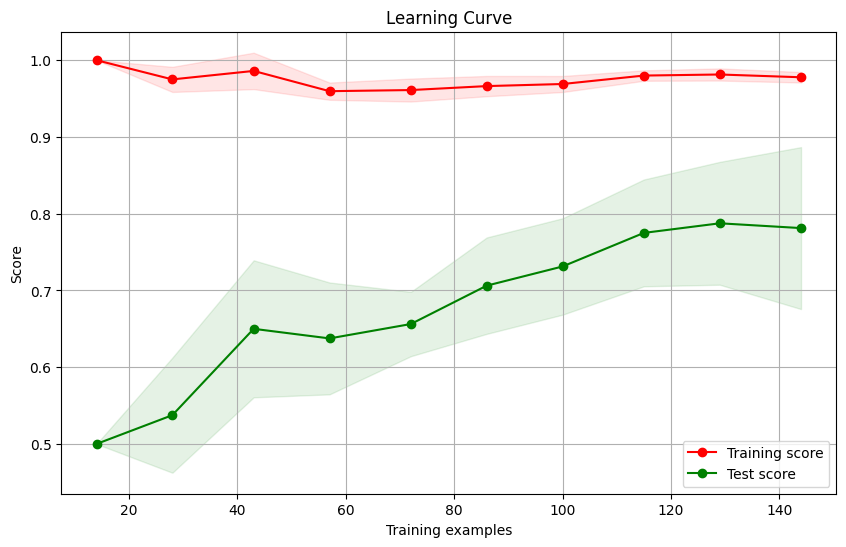

In [ ]:
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# is it good to plot the learning curve for the ensemble model? I think it's not it would disrupt the entire grid search and take ages
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(kernel= 'rbf'),
                                                     X_train_original,
                                                     y_train,
                                                     cv=10,
                                                     n_jobs=-1,
                                                     train_sizes=np.linspace(.1, 1.0, 10))
print(train_scores, test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#fit_times_mean = np.mean(fit_times, axis=1)
#fit_times_std = np.std(fit_times, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Test score")

plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.show()

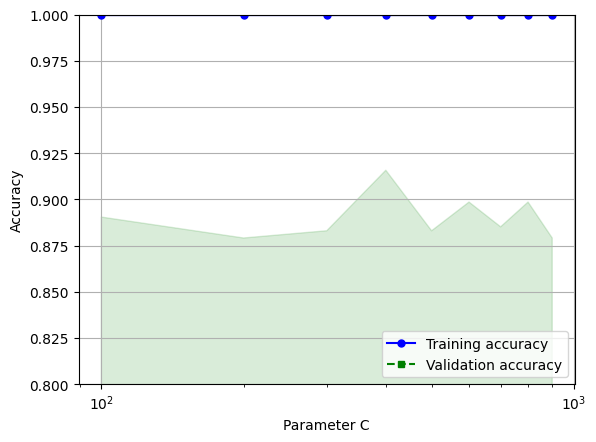

In [ ]:
# doesn't work, I think it's because the model is not a classifier, it's a MajorityVoteClassifier
param_range = np.arange(100, 1000, 100)
train_scores, test_scores = validation_curve(estimator=RandomForestClassifier(random_state=1),
                                             X=X_train_original,
                                             y=y_train,
                                             param_name='n_estimators',
                                             param_range=param_range,
                                             cv=10,
                                             n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                    train_mean - train_std, alpha=0.15,
                    color='blue')

plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

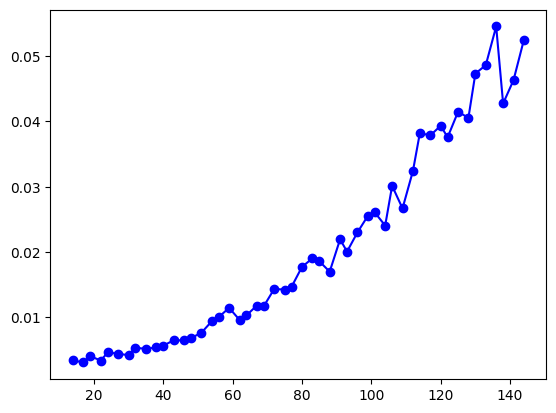

In [ ]:
# train times are cool, but out of scope for this project
plt.plot(train_sizes, fit_times_mean, 'o-', color="b",
        label="Fit times")

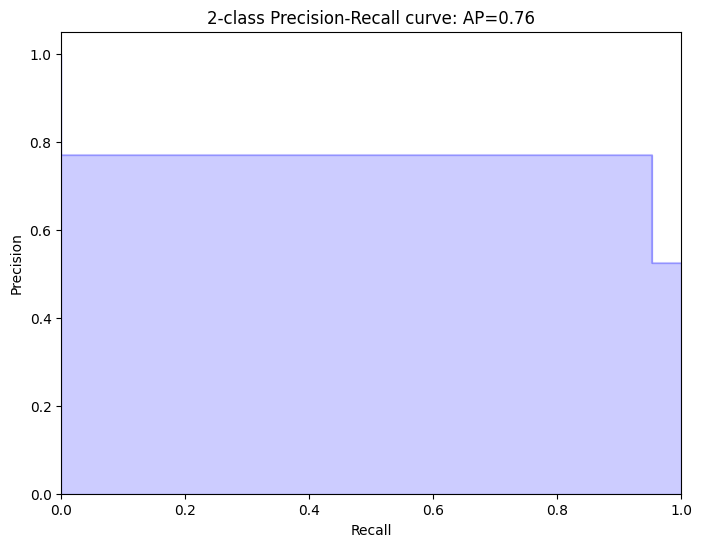

In [ ]:
# not really aesthetically pleasing
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=4)
    average_precision = average_precision_score(y_true, y_score, pos_label=4)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

plot_precision_recall_curve(models['original']['labels'], models['original']['model'].predict(models['original']['features']))

## Outlier detection

In [ ]:
# first approach
outliers = []
std_range = mean

for row in range (0, len(df)):
    sum = 0
    for value in df.iloc[row]:
        if value > std_range or value < -std_range:
            sum += 1
    if sum >= 2048:
        outliers.append(True)
    else:
        outliers.append(False)

df[df.columns[0]][outliers]

NameError: name 'mean' is not defined

In [ ]:
# second approach, not final

from sklearn import model_selection

perc_outlier = .5

t3 = df[df['y'] == 3]
t4 = df[df['y'] == 4]
del t3['y']
del t4['y']

t3_train, t3_test = model_selection.train_test_split(t3, test_size=.2, shuffle=True)
t4_train, t4_test = model_selection.train_test_split(t4, test_size=.2, shuffle=True)

# outlier detection for the training set
t3_train_std = t3_train.std(axis=0)
t3_train_mean = t3_train.mean(axis=0)

t3_train_outliers_indices = ((((t3 > t3_train_mean+t3_train_std) | (t3 < t3_train_mean-t3_train_std)).sum(axis= 1)) > t3.shape[1] * perc_outlier)
print(t3_train_outliers_indices.sum())


t4_train_std = t4_train.std(axis=0)
t4_train_mean = t4_train.mean(axis=0)

t4_train_outliers_indices = ((((t3 > t4_train_mean+t4_train_std) | (t3 < t4_train_mean-t4_train_std)).sum(axis= 1)) > t3.shape[1] * perc_outlier)
print(t4_train_outliers_indices.sum())


# outlier detection for the test set
t3_test_std = t3_test.std(axis=0)
t3_test_mean = t3_test.mean(axis=0)

t3_test_outliers_indices = ((((t3_test > t3_test_mean + t3_test_std) | (t3_test < t3_test_mean - t3_test_std)).sum(axis=1)) > t3_test.shape[1] * perc_outlier)
print(t3_test_outliers_indices.sum())

t4_test_std = t4_test.std(axis=0)
t4_test_mean = t4_test.mean(axis=0)

t4_test_outliers_indices = ((((t4_test > t4_test_mean + t4_test_std) | (t4_test < t4_test_mean - t4_test_std)).sum(axis=1)) > t4_test.shape[1] * perc_outlier)
print(t4_test_outliers_indices.sum())


# t34 = pd.concat([df[df['y'] == 3], df[df['y'] == 4]], ignore_index=True)

# labels = t34['y'] # save labels in a different list
# del t34['y'] # drop the column from the dataset

# # split training and test set
# data_train, data_test, labels_train, labels_test = model_selection.train_test_split(t34, labels, test_size=.2, shuffle=True)

6
1
1
0
